In [85]:
import xarray as xr
from cdo import *
import cdo
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import cartopy.crs as ccrs
import subprocess
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

In [48]:
results = xr.open_dataset("input.nc",decode_times=True)
amoc = xr.open_dataset("amoc.nc")
outfile = './outfile.nc'
rootgrp = Dataset("input.nc", "r", format="NETCDF4")
tas = xr.open_dataset('input.nc').tas[0,:,:]
land_sea = xr.open_dataset('land_sea_mask.nc')
tas_ocean = xr.open_dataset('tas_ocean.nc')
ts_ocean = xr.open_dataset('ts_ocean.nc')
ls_precip = xr.open_dataset('prl.nc')
convective_precip = xr.open_dataset('prc.nc')

In [3]:
cdo = Cdo()

In [4]:
tas_ocean.head()

<xarray.Dataset> Size: 700B
Dimensions:    (time: 5, bnds: 2, lon: 5, lat: 5)
Coordinates:
  * time       (time) float64 40B 1.012e+04 1.021e+04 ... 1.042e+04 1.052e+04
  * lon        (lon) float64 40B 0.0 5.625 11.25 16.88 22.5
  * lat        (lat) float64 40B 85.76 80.27 74.74 69.21 63.68
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 80B ...
    tas        (time, lat, lon) float32 500B ...
Attributes:
    CDI:          Climate Data Interface version 2.5.3 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    frequency:    mon
    history:      Mon Sep 08 17:27:43 2025: cdo mul sst.nc ocean_mask.nc tas_...
    CDO:          Climate Data Operators version 2.5.3 (https://mpimet.mpg.de...

In [50]:
df_tas = tas_ocean["tas"].to_dataframe().reset_index()
df_ts = ts_ocean["ts"].to_dataframe().reset_index()
df_prl = ls_precip['prl'].to_dataframe().reset_index()
df_prc = convective_precip['prc'].to_dataframe().reset_index()
df_ts.head()

,time,lat,lon,ts
0,10116.0,85.760587,0.000,-221.626511
1,10116.0,85.760587,5.625,-221.258240
2,10116.0,85.760587,11.250,-221.085953
3,10116.0,85.760587,16.875,-220.741486
4,10116.0,85.760587,22.500,-220.444061


In [41]:
def preprocess(df,var):
    #average time values
    df_avg = df.groupby(['lat','lon'])[var].mean().reset_index()
    #replace land mask with 220 values
    df_avg[var] = np.where(df_avg[var] == 0.0, 220, df_avg[var])
    #get absolute value (fix for land sea mask)
    df_avg[var] = np.abs(df_avg[var])

    return df_avg


In [74]:
tas_df = preprocess(df_tas,'tas')
ts_df = preprocess(df_ts,'ts')
lsp_df = preprocess(df_prl,'prl')
conp_df = preprocess(df_prc,'prc')
lsp_df.head()

,lat,lon,prl
0,-85.760587,0.000,2.966005e-09
1,-85.760587,5.625,3.075937e-09
2,-85.760587,11.250,3.221625e-09
3,-85.760587,16.875,3.452670e-09
4,-85.760587,22.500,3.833662e-09


In [105]:
def draw_maps(df,title,values,label):
    #shift 'seam' of map to pacific ocean
    df['lon'] = (df['lon'] + 180) % 360 - 180
    
    map = Basemap(projection='ortho',lat_0=30,lon_0=-50,resolution='l')
    # draw coastlines, country boundaries, fill continents.
    map.drawcoastlines(linewidth=0.25)
    map.drawcountries(linewidth=0.25)
    map.fillcontinents(color='#4863A0',lake_color='#D3D3D3')
    # draw the edge of the map projection region (the projection limb)
    map.drawmapboundary(fill_color='grey')
    # draw lat/lon grid lines every 30 degrees.
    map.drawmeridians(np.arange(0,360,30))
    map.drawparallels(np.arange(-90,90,30))
    
    # make mapgrid using lat and lon values
    lats = np.sort(df['lat'].unique())
    lons = np.sort(df['lon'].unique())
    grid = df.pivot(index='lat', columns='lon', values=values).values
    
    # Create meshgrid for Basemap
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    x, y = map(lon_grid, lat_grid)
    
    cs = map.contourf(x, y, grid, levels=20, cmap='coolwarm')
    cbar = plt.colorbar(cs, orientation='vertical', label=label)
    
    # Replace the top tick with "Land"
    ticks = cbar.get_ticks()
    tick_labels = [f"{t:.1f}" for t in ticks]
    
    # If 220 is in ticks, replace it with "Land"
    if 220 in ticks:
        tick_labels[ticks.tolist().index(220)] = "Land"
    
    cbar.set_ticks(ticks)
    cbar.set_ticklabels(tick_labels)
    
    plt.title(title)
    plt.show()

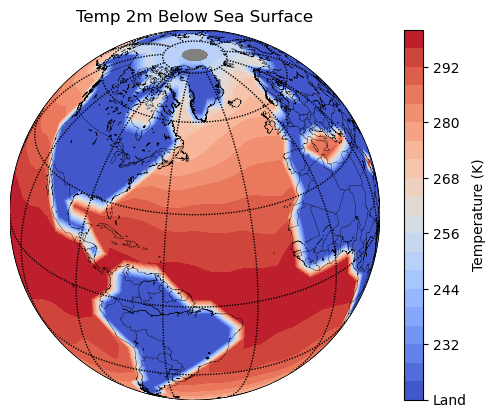

In [89]:
draw_maps(tas_df,'Temp 2m Below Sea Surface','tas','Temperature (K)')

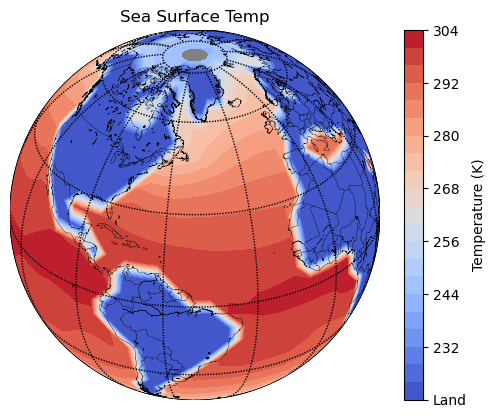

In [90]:
draw_maps(ts_df,'Sea Surface Temp','ts','Temperature (K)')

In [109]:
def process_precip(df,var):
    #remove weirdly high values
    filtered_df = df.loc[df[var]<10]
    #convert m/s to mm/day
    filtered_df[var] = filtered_df[var] * 86400 * 1000
    filtered_df.head()
    return filtered_df

In [110]:
processed_lsp = process_precip(lsp_df,'prl')
processed_cp = process_precip(conp_df,'prc')

/var/folders/v1/ymptnwwx3x1b7_mw0nns09wr0000gn/T/ipykernel_5785/3960495893.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[var] = filtered_df[var] * 86400 * 1000


/var/folders/v1/ymptnwwx3x1b7_mw0nns09wr0000gn/T/ipykernel_5785/619616120.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lon'] = (df['lon'] + 180) % 360 - 180


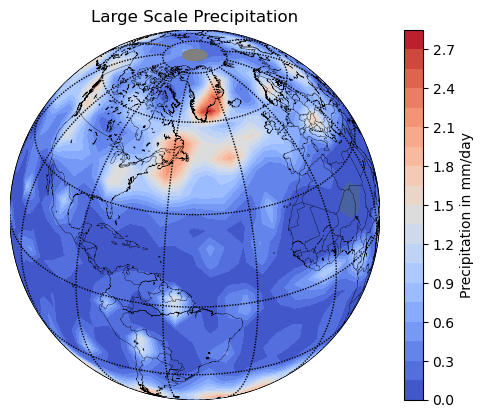

In [111]:
draw_maps(processed_lsp,'Large Scale Precipitation','prl','Precipitation in mm/day')

/var/folders/v1/ymptnwwx3x1b7_mw0nns09wr0000gn/T/ipykernel_5785/619616120.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lon'] = (df['lon'] + 180) % 360 - 180


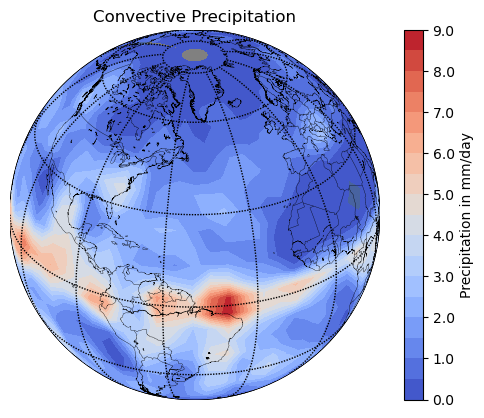

In [113]:
draw_maps(processed_cp,'Convective Precipitation','prc','Precipitation in mm/day')

In [9]:
cdo.selvar('tas', input=results, output=outfile)
cdo.sinfon(input=outfile)

['File format : NetCDF4',
 '-1 : Institut Source   T Steptype Levels Num    Points Num Dtype : Parameter name',
 '1 : unknown  unknown  v instant       1   1      2048   1  F32  : tas',
 'Grid coordinates :',
 '1 : gaussian                 : points=2048 (64x32)  F16',
 'lon : 0 to 354.375 by 5.625 [degrees_east]  circular',
 'lat : 85.76059 to -85.76059 [degrees_north]',
 'Vertical coordinates :',
 '1 : surface                  : levels=1',
 'Time coordinate :',
 'time : 12 steps',
 'YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss',
 '0001-01-16 00:00:00  0001-02-14 12:00:00  0001-03-16 00:00:00  0001-04-15 12:00:00',
 '0001-05-16 00:00:00  0001-06-15 12:00:00  0001-07-16 00:00:00  0001-08-16 00:00:00',
 '0001-09-15 12:00:00  0001-10-16 00:00:00  0001-11-15 12:00:00  0001-12-16 00:00:00']

In [10]:
lat = rootgrp.variables['lat'][:]
lon = rootgrp.variables['lon'][:]
time = rootgrp.variables['time'][:]
print(time)

[10116.  10214.5 10316.  10415.5 10516.  10615.5 10716.  10816.  10915.5
 11016.  11115.5 11216. ]


In [50]:
precipitation = cdo.selvar('tas', input=results, returnXArray='tas')
print(precipitation)

<xarray.DataArray 'tas' (time: 12, lat: 32, lon: 64)> Size: 98kB
[24576 values with dtype=float32]
Coordinates:
  * time     (time) float64 96B 1.012e+04 1.021e+04 ... 1.112e+04 1.122e+04
  * lon      (lon) float64 512B 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * lat      (lat) float64 256B 85.76 80.27 74.74 69.21 ... -74.74 -80.27 -85.76
Attributes:
    long_name:         Temperature at 2m
    units:             K
    code:              167
    CDI_grid_type:     gaussian
    CDI_grid_num_LPE:  16
    cell_methods:      time: mean


In [107]:
amoc.head()
df_amoc = amoc["tas"].to_dataframe().reset_index()
df_amoc.tail()

,time,lat,lon,tas
1759,11216.0,24.919929,-5.625,284.929047
1760,11216.0,24.919929,0.000,282.642212
1761,11216.0,24.919929,5.625,281.543365
1762,11216.0,24.919929,11.250,280.805115
1763,11216.0,24.919929,16.875,280.023163


In [27]:
df_amoc.to_csv("amoc.csv")

In [20]:
df_surface_temp = surface_temp["tas"].to_dataframe().reset_index()

In [22]:
df_surface_temp.to_csv("surface_temp.csv")